In [1]:
import os
import json
import random 
import math
import numpy as np
from tqdm import tqdm
from copy import deepcopy

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, Tensor
from torch.nn import functional as F 
from torch.optim import Adam

from scipy.signal import resample
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

---
Data & Configuration setup

In [2]:
# build PAMAP2 dataset data reader
class PAMAP2Reader(object):
    def __init__(self, root_path):
        self.root_path = root_path
        self.readPamap2()

    def readFile(self, file_path):
        all_data = {"data": {}, "target": {}, 'collection': []}
        prev_action = -1
        starting = True
        # action_seq = []
        action_ID = 0
        for l in open(file_path).readlines():
            s = l.strip().split()
            if s[1] != "0":
                if (prev_action != int(s[1])):
                    if not(starting):
                        all_data['data'][action_ID] = np.array(action_seq)
                        all_data['target'][action_ID] = prev_action
                        action_ID+=1
                    action_seq = []
                else:
                    starting = False
                data_seq = np.nan_to_num(np.array(s[3:]), nan=0).astype(np.float16)
                # data_seq[np.isnan(data_seq)] = 0
                action_seq.append(data_seq)
                prev_action = int(s[1])
                all_data['collection'].append(data_seq)
        return all_data

    def readPamap2Files(self, filelist, cols, labelToId):
        data = []
        labels = []
        collection = []
        for i, filename in enumerate(filelist):
            print('Reading file %d of %d' % (i+1, len(filelist)))
            fpath = os.path.join(self.root_path, filename)
            file_data = self.readFile(fpath)
            data.extend(list(file_data['data'].values()))
            labels.extend(list(file_data['target'].values()))
            collection.extend(file_data['collection'])
        return np.asarray(data), np.asarray(labels).astype(int), np.array(collection)

    def readPamap2(self):
        files = ['subject101.dat', 'subject102.dat','subject103.dat','subject104.dat', 'subject105.dat', 'subject106.dat', 'subject107.dat', 'subject108.dat', 'subject109.dat']
            
        label_map = [
            #(0, 'other'),
            (1, 'lying'),
            (2, 'sitting'),
            (3, 'standing'),
            (4, 'walking'),
            (5, 'running'),
            (6, 'cycling'),
            (7, 'Nordic walking'),
            (9, 'watching TV'),
            (10, 'computer work'),
            (11, 'car driving'),
            (12, 'ascending stairs'),
            (13, 'descending stairs'),
            (16, 'vacuum cleaning'),
            (17, 'ironing'),
            (18, 'folding laundry'),
            (19, 'house cleaning'),
            (20, 'playing soccer'),
            (24, 'rope jumping')
        ]
        labelToId = {x[0]: i for i, x in enumerate(label_map)}
        # print "label2id=",labelToId
        idToLabel = [x[1] for x in label_map]
        # print "id2label=",idToLabel
        cols = [
                1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
                35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53
                ]
        # print "cols",cols
        self.data, self.targets, self.all_data = self.readPamap2Files(files, cols, labelToId)
        # print(self.data)
        # nan_perc = np.isnan(self.data).astype(int).mean()
        # print("null value percentage ", nan_perc)
        # f = lambda x: labelToId[x]
        self.targets = np.array([labelToId[i] for i in list(self.targets)])
        self.label_map = label_map
        self.idToLabel = idToLabel
        # return data, idToLabel

    def resampling(self, data, targets):
        assert len(data) == len(targets), "# action data & # action labels are not matching"
        all_data, all_ids, all_labels = [], [], []
        for i, d in enumerate(data):
            l, _ = d.shape 
            label = targets[i]
            if l < 1200 : # minimum length requirement
                break 
            # generate sampling points
            n_point, _ = divmod(l, 1200)
            sampling_points = np.arange(start=0, stop=l, step=1200)[:-1]
            sampling_points = sampling_points-200
            sampling_points[0] = 0
            # print(l, sampling_points)
            # window sampling 
            for s in sampling_points:
                sub_sample = np.nan_to_num(resample(d[s:s+1200, :], num=120, axis=0), nan=0)
                # print(d[s:s+1200, :])
                nan_perc = np.isnan(sub_sample).astype(int).mean()
                # print("null value percentage ", nan_perc, "id > ", i+1)
                all_data.append(sub_sample)
                all_ids.append(i+1)
                all_labels.append(label)
            
        return all_data, all_ids, all_labels

    def generate(self, unseen_classes, resampling=True, seen_ratio=0.2, unseen_ratio=0.8):
        # assert all([i in list(self.label_map.keys()) for i in unseen_classes]), "Unknown Class label!"
        seen_classes = [i for i in range(len(self.idToLabel)) if i not in unseen_classes]
        unseen_mask = np.in1d(self.targets, unseen_classes)

        # normalize data [without considering ]
        # scaler = MinMaxScaler()
        # scaler.fit(self.all_data)
        # self.data = np.array([scaler.transform(d) for d in self.data])

        # build seen dataset 
        seen_data = self.data[np.invert(unseen_mask)]
        seen_targets = self.targets[np.invert(unseen_mask)]

        # build unseen dataset
        unseen_data = self.data[unseen_mask]
        unseen_targets = self.targets[unseen_mask]

        # resampling seen and unseen datasets 
        seen_data, seen_ids, seen_targets = self.resampling(seen_data, seen_targets)
        unseen_data, unseen_ids, unseen_targets = self.resampling(unseen_data, unseen_targets)

        seen_data, seen_targets = np.array(seen_data), np.array(seen_targets)
        unseen_data, unseen_targets = np.array(unseen_data), np.array(unseen_targets)
        # train-val split
        seen_index = list(range(len(seen_targets)))
        random.shuffle(seen_index)
        random.shuffle(seen_index)
        split_point = int((1-seen_ratio)*len(seen_index))
        fst_index, sec_index = seen_index[:split_point], seen_index[split_point:]
        # print(type(fst_index), type(sec_index), type(seen_data), type(seen_targets))
        X_seen_train, X_seen_val, y_seen_train, y_seen_val = seen_data[fst_index,:], seen_data[sec_index,:], seen_targets[fst_index], seen_targets[sec_index]
        
        # val-test split
        unseen_index = list(range(len(unseen_targets)))
        random.shuffle(unseen_index)
        split_point = int((1-unseen_ratio)*len(unseen_index))
        fst_index, sec_index = unseen_index[:split_point], unseen_index[split_point:]

        X_unseen_val, X_unseen_test, y_unseen_val, y_unseen_test = unseen_data[fst_index,:], unseen_data[sec_index,:], unseen_targets[fst_index], unseen_targets[sec_index]

        data = {'train': {
                        'X': X_seen_train,
                        'y': y_seen_train
                        },
                'eval-seen':{
                        'X': X_seen_val,
                        'y': y_seen_val
                        },
                'eval-unseen':{
                        'X': X_unseen_val,
                        'y': y_unseen_val
                        },
                'test': {
                        'X': X_unseen_test,
                        'y': y_unseen_test
                        },
                'seen_classes': seen_classes,
                'unseen_classes': unseen_classes
                }

        return data
        

In [3]:
# import action attributes
def load_attribute(fpath):
    with open(fpath, "r") as pf:
        json_data = json.load(pf)

    activity_dict = json_data["Activity"]
    attribute_dict = json_data["Attribute"]
    attr_met = np.array(list(json_data["Mark"].values()))
    return activity_dict, attribute_dict, attr_met

In [4]:
# import action semantic features 
# generate random feature matrix 
feat_size = 64
n_actions = 18 
feat_mat = np.random.randn(n_actions, feat_size)

---
DataSet Classes & DataLoaders

In [5]:
# build mock dataloader
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, action_feats, action_classes):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attributes = torch.from_numpy(attributes)
        self.action_feats = torch.from_numpy(action_feats)
        self.target_feat = torch.from_numpy(action_feats[action_classes, :])
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        x_mask = np.array([0]) #self.padding_mask[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        y_feat = self.action_feats[target, ...]
        attr = self.attributes[target, ...]
        return x, y, y_feat, attr, x_mask

    def __len__(self):
        return self.data.shape[0]


---
Setup Model

In [6]:
# relative global attention based transformer encoder implementation
class RelativeGlobalAttention(nn.Module):
    def __init__(self, d_model, num_heads, max_len=1024, dropout=0.1):
        super().__init__()
        d_head, remainder = divmod(d_model, num_heads)
        if remainder:
            raise ValueError(
                "incompatible `d_model` and `num_heads`"
            )
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.query = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.Er = nn.Parameter(torch.randn(max_len, d_head))
        self.register_buffer(
            "mask", 
            torch.tril(torch.ones(max_len, max_len))
            .unsqueeze(0).unsqueeze(0)
        )

    
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        if seq_len > self.max_len:
            raise ValueError(
                "sequence length exceeds model capacity"
            )
        
        k_t = self.key(x).reshape(batch_size, seq_len, self.num_heads, -1).permute(0, 2, 3, 1)
        v = self.value(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        q = self.query(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        
        start = self.max_len - seq_len
        Er_t = self.Er[start:, :].transpose(0, 1) # automatic positional padding
        QEr = torch.matmul(q, Er_t)
        Srel = self.skew(QEr)
        
        QK_t = torch.matmul(q, k_t)
        attn = (QK_t + Srel) / math.sqrt(q.size(-1))
        mask = self.mask[:, :, :seq_len, :seq_len]
        attn = attn.masked_fill(mask == 0, float("-inf"))
        attn = F.softmax(attn, dim=-1)
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2)
        out = out.reshape(batch_size, seq_len, -1)
        return self.dropout(out)
        
    
    def skew(self, QEr):
        padded = F.pad(QEr, (1, 0))
        batch_size, num_heads, num_rows, num_cols = padded.shape
        reshaped = padded.reshape(batch_size, num_heads, num_cols, num_rows)
        Srel = reshaped[:, :, 1:, :]
        return Srel

In [7]:
# build E2E ZSL HAR Model
class ZSLHARNet(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, ft_size, attr_size, max_len=1024, dropout=0.1):
        super().__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size # semantic space size <-> output feature space size
        self.attr_size = attr_size # intermediate attribute space size 

        # custom sample layer configuration
        # Dense layer for feature projection
        self.DenseL = nn.Linear(in_ft, d_model)
        # attention encoder <-> global relative attention used here
        self.AttnL = RelativeGlobalAttention(d_model, num_heads, max_len)
        # positional encoding concat <-> LSTM 
        self.lstmL = nn.LSTM(input_size=d_model, hidden_size=ft_size, batch_first=True)
        # SAE submodule
        self.EncDenseL = nn.Linear(in_features=ft_size, out_features=attr_size, bias=False)
        self.DecDenseL = nn.Linear(in_features=attr_size, out_features=ft_size, bias=False)
        # override weights
        del self.EncDenseL.weight
        del self.DecDenseL.weight
        # define shared weights
        self.TransMet = nn.Parameter(torch.randn(attr_size, ft_size))


    def forward(self, x):
        out = self.DenseL(x)
        out = self.AttnL(out)
        lstm_out, hidden = self.lstmL(out)
        # SAE Operation
        self.EncDenseL.weight = self.TransMet
        self.DecDenseL.weight = self.TransMet.T 
        attr_out = self.EncDenseL(lstm_out[:, -1, :])
        ft_out = self.DecDenseL(attr_out)
        return attr_out, ft_out

---
Setup Training & evaluation pipeline

In [8]:
def plot_confusion_matrix(ConfMat, label_strings=None, title='Confusion matrix', cmap=plt.cm.get_cmap('Blues')):
    """Plot confusion matrix in a separate window"""
    plt.imshow(ConfMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if label_strings:
        tick_marks = np.arange(len(label_strings))
        plt.xticks(tick_marks, label_strings, rotation=90)
        plt.yticks(tick_marks, label_strings)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def generate_classification_report(existing_class_names, precision, recall, f1, support, ConfMatrix_normalized_row, digits=3, number_of_thieves=2, maxcharlength=35):
    """
    Returns a string of a report for given metric arrays (array length equals the number of classes).
    Called internally by `analyze_classification`.
        digits: number of digits after . for displaying results
        number_of_thieves: number of biggest thieves to report
        maxcharlength: max. number of characters to use when displaying thief names
    """

    relative_freq = support / np.sum(support)  # relative frequencies of each class in the true lables
    sorted_class_indices = np.argsort(relative_freq)[
                            ::-1]  # sort by "importance" of classes (i.e. occurance frequency)

    last_line_heading = 'avg / total'

    width = max(len(cn) for cn in existing_class_names)
    width = max(width, len(last_line_heading), digits)

    headers = ["precision", "recall", "f1-score", "rel. freq.", "abs. freq.", "biggest thieves"]
    fmt = '%% %ds' % width  # first column: class name
    fmt += '  '
    fmt += ' '.join(['% 10s' for _ in headers[:-1]])
    fmt += '|\t % 5s'
    fmt += '\n'

    headers = [""] + headers
    report = fmt % tuple(headers)
    report += '\n'

    for i in sorted_class_indices:
        values = [existing_class_names[i]]
        for v in (precision[i], recall[i], f1[i],
                    relative_freq[i]):  # v is NOT a tuple, just goes through this list 1 el. at a time
            values += ["{0:0.{1}f}".format(v, digits)]
        values += ["{}".format(support[i])]
        thieves = np.argsort(ConfMatrix_normalized_row[i, :])[::-1][
                    :number_of_thieves + 1]  # other class indices "stealing" from class. May still contain self
        thieves = thieves[thieves != i]  # exclude self at this point
        steal_ratio = ConfMatrix_normalized_row[i, thieves]
        thieves_names = [
            existing_class_names[thief][:min(maxcharlength, len(existing_class_names[thief]))] for thief
            in thieves]  # a little inefficient but inconsequential
        string_about_stealing = ""
        for j in range(len(thieves)):
            string_about_stealing += "{0}: {1:.3f},\t".format(thieves_names[j], steal_ratio[j])
        values += [string_about_stealing]

        report += fmt % tuple(values)

    report += '\n' + 100 * '-' + '\n'

    # compute averages/sums
    values = [last_line_heading]
    for v in (np.average(precision, weights=relative_freq),
                np.average(recall, weights=relative_freq),
                np.average(f1, weights=relative_freq)):
        values += ["{0:0.{1}f}".format(v, digits)]
    values += ['{0}'.format(np.sum(relative_freq))]
    values += ['{0}'.format(np.sum(support))]
    values += ['']

    # make last ("Total") line for report
    report += fmt % tuple(values)

    return report


def action_evaluator(y_pred, y_true, class_names, excluded_classes=None, maxcharlength=35):
    """
    For an array of label predictions and the respective true labels, shows confusion matrix, accuracy, recall, precision etc:
    Input:
        y_pred: 1D array of predicted labels (class indices)
        y_true: 1D array of true labels (class indices)
        class_names: 1D array or list of class names in the order of class indices.
            Could also be integers [0, 1, ..., num_classes-1].
        excluded_classes: list of classes to be excluded from average precision, recall calculation (e.g. OTHER)
    """

    # Trim class_names to include only classes existing in y_pred OR y_true
    in_pred_labels = set(list(y_pred))
    in_true_labels = set(list(y_true))

    existing_class_ind = sorted(list(in_pred_labels | in_true_labels))
    # print("pred label", in_pred_labels, "true label", in_true_labels)
    class_strings = [str(name) for name in class_names]  # needed in case `class_names` elements are not strings
    existing_class_names = class_names #[class_strings[ind][:min(maxcharlength, len(class_strings[ind]))] for ind in existing_class_ind]  # a little inefficient but inconsequential

    # Confusion matrix
    ConfMatrix = metrics.confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix by row (i.e by the number of samples in each class)
    ConfMatrix_normalized_row = metrics.confusion_matrix(y_true, y_pred, normalize='true') #ConfMatrix.astype('float') / ConfMatrix.sum(axis=1)[:, np.newaxis] #@nipdep

    
    plt.figure()
    plot_confusion_matrix(ConfMatrix_normalized_row, label_strings=existing_class_names,
                            title='Confusion matrix normalized by row')
    plt.show(block=False)

    # Analyze results
    total_accuracy = np.trace(ConfMatrix) / len(y_true)
    print('Overall accuracy: {:.3f}\n'.format(total_accuracy))

    # returns metrics for each class, in the same order as existing_class_names
    precision, recall, f1, support = metrics.precision_recall_fscore_support(y_true, y_pred, labels=existing_class_ind, zero_division=0)
    # Print report
    print(generate_classification_report(existing_class_names, precision, recall, f1, support, ConfMatrix_normalized_row))

    # Calculate average precision and recall
    # prec_avg, rec_avg = get_avg_prec_recall(ConfMatrix, existing_class_names, excluded_classes)
    # if excluded_classes:
    #     print(
    #         "\nAverage PRECISION: {:.2f}\n(using class frequencies as weights, excluding classes with no predictions and predictions in '{}')".format(
    #             prec_avg, ', '.join(excluded_classes)))
    #     print(
    #         "\nAverage RECALL (= ACCURACY): {:.2f}\n(using class frequencies as weights, excluding classes in '{}')".format(
    #             rec_avg, ', '.join(excluded_classes)))

    # Make a histogram with the distribution of classes with respect to precision and recall
    # prec_rec_histogram(precision, recall)

    return {"total_accuracy": total_accuracy, "precision": precision.mean(), "recall": recall.mean(), "f1": f1.mean()}

In [9]:
def report_data(data_dict, all_class_names):
    # training dataset
    train_X, train_y = data_dict['train']['X'], data_dict['train']['y']
    print("number of training samples : ", len(train_y))
    s = np.unique(train_y, return_counts=True)
    print("per class count : ", dict(zip([all_class_names[i] for i in s[0]], s[1])))

    # Seen Evaluation dataset
    Seval_X, Seval_y = data_dict['eval-seen']['X'], data_dict['eval-seen']['y']
    print("number of training samples : ", len(Seval_y))
    s = np.unique(Seval_y, return_counts=True)
    print("per class count : ", dict(zip([all_class_names[i] for i in s[0]], s[1])))

    # Unseen Eval dataset
    Ueval_X, Ueval_y = data_dict['eval-unseen']['X'], data_dict['eval-unseen']['y']
    print("number of training samples : ", len(Ueval_y))
    s = np.unique(Ueval_y, return_counts=True)
    print("per class count : ", dict(zip([all_class_names[i] for i in s[0]], s[1])))

    # Unseen Eval dataset
    test_X, test_y = data_dict['test']['X'], data_dict['test']['y']
    print("number of training samples : ", len(test_y))
    s = np.unique(test_y, return_counts=True)
    print("per class count : ", dict(zip([all_class_names[i] for i in s[0]], s[1])))

    print("Total number of data points : ", len(test_y)+len(Ueval_y)+len(Seval_y)+len(train_y))
    print("Total number of unseen data : ", len(test_y)+len(Ueval_y))
    print("Total number of seen data : ", len(Seval_y)+len(train_y))

In [10]:
# build loss module
class FeatureLoss(nn.Module):
    def __init__(self):
        super(FeatureLoss, self).__init__()
        # self.add_aux = add_aux 
        self.loss_func = nn.CosineSimilarity(dim=1, eps=1e-6)

    def forward(self, y_pred, y_true):
        batch_loss = self.loss_func(y_pred, y_true)
        final_loss = torch.abs(batch_loss.mean())
        return final_loss

In [11]:
class AttributeLoss(nn.Module):
    def __init__(self):
        super(AttributeLoss, self).__init__()
        self.loss_func = nn.BCELoss()
        self.m = nn.Sigmoid()

    def forward(self, attr_pred, attr_true):
        # print("attr true > ", attr_true, "attr pred > ", attr_pred)
        output = self.loss_func(self.m(attr_pred), attr_true)
        return output

In [12]:
def train_step(model, dataloader, optimizer, loss_module, loss_alpha, device, class_names, target_feat_met, phase='train', l2_reg=False):
    model = model.train()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, target_attr, padding_masks = batch
            # print(X, targets, target_feat, target_attr)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            target_attr = target_attr.float().to(device)
            targets = targets.to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                attr_output, feat_output = model(X)
                # print("feature shape", feat_output.shape, "target feature shape", target_feat.shape)
                feat_loss = loss_module['feature'](feat_output, target_feat)
                attr_loss = loss_module['attribute'](attr_output, target_attr)

            # define composite loss function
            loss = loss_alpha*feat_loss+(1-loss_alpha)*attr_loss
            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            # if i % print_interval == 0:
            #     ending = "" if epoch_num is None else 'Epoch {} '.format(epoch_num)
            #     self.print_callback(i, metrics, prefix='Training ' + ending)

            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine 
            feat_numpy = feat_output.cpu().detach()
            action_probs = cosine_similarity(feat_numpy, target_feat_met)
            pred_action = np.argmax(action_probs, axis=1)
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_action)
            tepoch.set_postfix(metrics)
            
    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [13]:
def eval_step(model, dataloader, loss_module, loss_alpha, device, class_names, target_feat_met, phase='train', l2_reg=False):
    model = model.train()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, target_attr, padding_masks = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            target_attr = target_attr.float().to(device)
            targets = targets.to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                attr_output, feat_output = model(X)
                # print("feature shape", feat_output.shape, "target feature shape", target_feat.shape)
                feat_loss = loss_module['feature'](feat_output, target_feat)
                attr_loss = loss_module['attribute'](attr_output, target_attr)

            # define composite loss function
            loss = loss_alpha*feat_loss+(1-loss_alpha)*attr_loss

            # convert feature vector into action class
            # using cosine 
            feat_numpy = feat_output.cpu().detach()
            action_probs = cosine_similarity(feat_numpy, target_feat_met)
            pred_action = np.argmax(action_probs, axis=1)
            
            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action)
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})
    
    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    # print("Eval size >",all_preds.shape, all_targets[:, 0].shape)
    # print("prediction class counts > ", np.unique(all_preds, return_counts=True))
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names)
    return metrics_dict


---
Attribute evaluate

---
Main

Reading file 1 of 9
Reading file 2 of 9
Reading file 3 of 9
Reading file 4 of 9
Reading file 5 of 9
Reading file 6 of 9
Reading file 7 of 9
Reading file 8 of 9
Reading file 9 of 9


C:\Users\deela\AppData\Local\Temp\ipykernel_30120\1625862174.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels).astype(int), np.array(collection)


================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
number of training samples :  1007
per class count :  {'lying': 126, 'sitting': 117, 'walking': 133, 'running': 66, 'cycling': 104, 'Nordic walking': 117, 'descending stairs': 68, 'vacuum cleaning': 109, 'ironing': 167}
number of training samples :  252
per class count :  {'lying': 31, 'sitting': 34, 'walking': 39, 'running': 10, 'cycling': 29, 'Nordic walking': 35, 'descending stairs': 13, 'vacuum cleaning': 33, 'ironing': 28}
number of training samples :  48
per class count :  {'standing': 31, 'ascending stairs': 17}
number of training samples :  197
per class count :  {'standing': 124, 'ascending stairs': 73}
Total number of data points :  1504
Total number of unseen data :  245
Total number of seen data :  1259


eval: 100%|██████████| 8/8 [00:01<00:00,  7.42batch/s, loss=0.182]


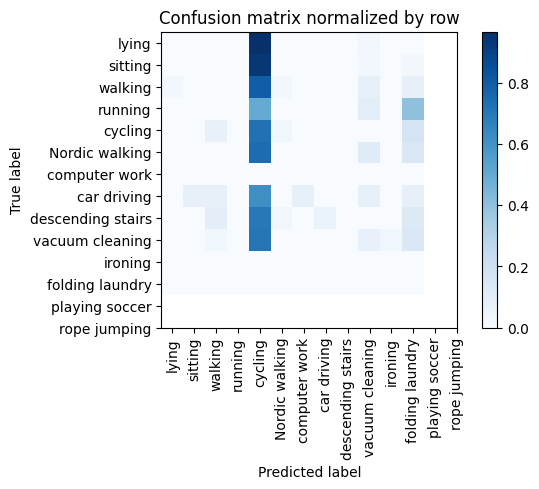

Training Epoch:  33%|███▎      | 1/3 [00:12<00:24, 12.42s/it]

Overall accuracy: 0.091

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.000      0.000      0.000      0.155         39|	 cycling: 0.795,	folding laundry: 0.077,	vacuum cleaning: 0.077,	
   Nordic walking       0.000      0.000      0.000      0.139         35|	 cycling: 0.743,	folding laundry: 0.143,	vacuum cleaning: 0.114,	
          sitting       0.000      0.000      0.000      0.135         34|	 cycling: 0.941,	folding laundry: 0.029,	vacuum cleaning: 0.029,	
descending stairs       0.000      0.000      0.000      0.131         33|	 cycling: 0.697,	folding laundry: 0.121,	walking: 0.091,	
            lying       0.000      0.000      0.000      0.123         31|	 cycling: 0.968,	vacuum cleaning: 0.032,	folding laundry: 0.000,	
          cycling       0.107      0.724      0.187      0.115         29|	 folding laundry: 0.172,	walking: 0.069,	
  vacuum cleaning       0.154      0.071      0.098      0.111      

eval: 100%|██████████| 8/8 [00:00<00:00,  8.13batch/s, loss=0.151]


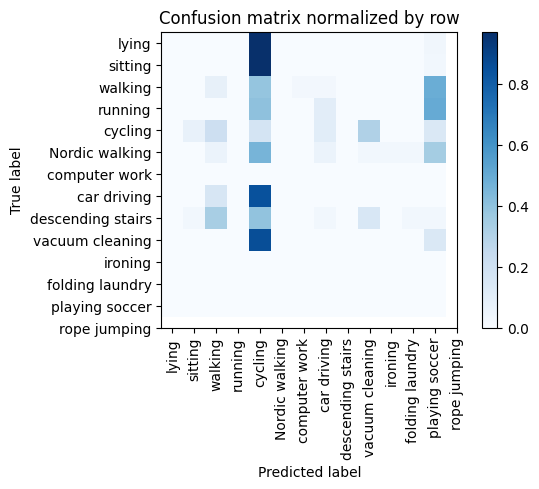

Training Epoch:  67%|██████▋   | 2/3 [00:23<00:11, 11.39s/it]

Overall accuracy: 0.032

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.125      0.077      0.095      0.155         39|	 playing soccer: 0.487,	cycling: 0.385,	
   Nordic walking       0.000      0.000      0.000      0.139         35|	 cycling: 0.457,	playing soccer: 0.343,	car driving: 0.057,	
          sitting       0.000      0.000      0.000      0.135         34|	 cycling: 0.971,	playing soccer: 0.029,	folding laundry: 0.000,	
descending stairs       0.000      0.000      0.000      0.131         33|	 cycling: 0.394,	walking: 0.333,	vacuum cleaning: 0.152,	
            lying       0.000      0.000      0.000      0.123         31|	 cycling: 0.968,	playing soccer: 0.032,	folding laundry: 0.000,	
          cycling       0.033      0.172      0.056      0.115         29|	 vacuum cleaning: 0.310,	walking: 0.207,	
  vacuum cleaning       0.000      0.000      0.000      0.111         28|	 cycling: 0.857,	playing 

eval: 100%|██████████| 8/8 [00:00<00:00,  8.61batch/s, loss=0.134]


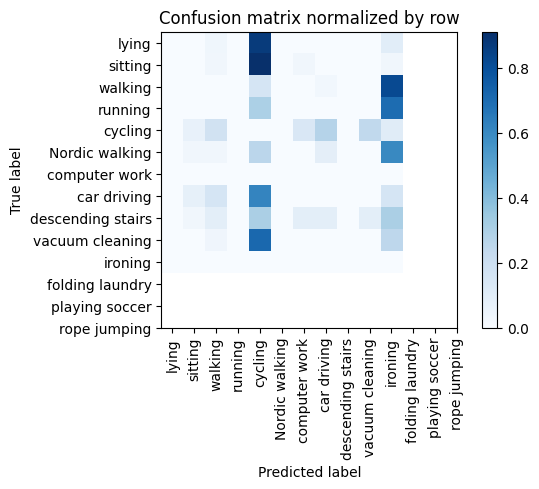

Overall accuracy: 0.000

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.000      0.000      0.000      0.155       39.0|	 ironing: 0.821,	cycling: 0.154,	car driving: 0.026,	
   Nordic walking       0.000      0.000      0.000      0.139       35.0|	 ironing: 0.600,	cycling: 0.257,	car driving: 0.086,	
          sitting       0.000      0.000      0.000      0.135       34.0|	 cycling: 0.912,	ironing: 0.029,	computer work: 0.029,	
descending stairs       0.000      0.000      0.000      0.131       33.0|	 ironing: 0.303,	cycling: 0.303,	vacuum cleaning: 0.091,	
            lying       0.000      0.000      0.000      0.123       31.0|	 cycling: 0.871,	ironing: 0.097,	walking: 0.032,	
          cycling       0.000      0.000      0.000      0.115       29.0|	 car driving: 0.276,	vacuum cleaning: 0.241,	walking: 0.172,	
  vacuum cleaning       0.000      0.000      0.000      0.111       28.0|	 cycling: 0.714,	ironin

eval: 100%|██████████| 7/7 [00:00<00:00, 10.26batch/s, loss=0.15] 


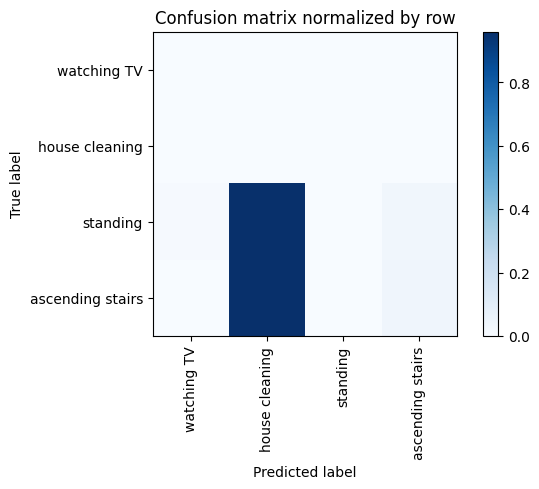

Overall accuracy: 0.015

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.000      0.000      0.000      0.629        124|	 house cleaning: 0.960,	ascending stairs: 0.032,	watching TV: 0.008,	
ascending stairs       0.429      0.041      0.075      0.371         73|	 house cleaning: 0.959,	standing: 0.000,	
  house cleaning       0.000      0.000      0.000      0.000          0|	 ascending stairs: 0.000,	standing: 0.000,	
     watching TV       0.000      0.000      0.000      0.000          0|	 ascending stairs: 0.000,	standing: 0.000,	house cleaning: 0.000,	

----------------------------------------------------------------------------------------------------
     avg / total       0.159      0.015      0.028        1.0        197|	      

{'total_accuracy': 0.015228426395939087, 'precision': 0.10714285714285714, 'recall': 0.010273972602739725, 'f1': 0.01875}


In [14]:
# run 
device = "cpu"#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# import PAMAP2 dataset
dataReader = PAMAP2Reader('../data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel
# import PAMAP2 attributes
activity_dict, attribute_dict, attr_mat = load_attribute('./PAMAP2_attributes.json')
_, attr_size = attr_mat.shape
# import action features
feat_size = 64
n_actions = 18 
feat_mat = np.random.randn(n_actions, feat_size) 

# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]
for i, cs in enumerate(fold_cls_ids):
    # separate seen/unseen and train/eval 
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')
    data_dict = dataReader.generate(unseen_classes=cs, resampling=True, seen_ratio=0.2, unseen_ratio=0.8)
    report_data(data_dict, actionList)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    train_n, seq_len, in_ft = data_dict['train']['X'].shape
    # build train_dt 
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    train_dl = DataLoader(train_dt, batch_size=32, shuffle=True, pin_memory=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    eval_dl = DataLoader(eval_dt, batch_size=32, shuffle=True, pin_memory=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=unseen_classes)
    test_dl = DataLoader(test_dt, batch_size=32, shuffle=True, pin_memory=True)
    
    # build model
    model = ZSLHARNet(in_ft=in_ft, d_model=128, num_heads=8, ft_size=feat_size, attr_size=attr_size, max_len=seq_len)
    model.to(device)
    # define run parameters 
    lr = 0.001
    epochs = 3
    optimizer = Adam(model.parameters(), lr=lr)
    loss_module = {'feature': FeatureLoss(), 'attribute': AttributeLoss()}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(epochs), desc='Training Epoch', leave=False):
        train_metrics = train_step(model, train_dl, optimizer, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes], target_feat_met=train_dt.target_feat, phase='train')
        eval_metrics = eval_step(model, eval_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.target_feat, phase='eval')
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    if best_acc == 0.0:
        best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.target_feat, phase='eval')
    print(test_metrics)
    print("="*40)
    break

In [15]:
attr_mat.shape

(18, 42)

In [16]:
feat_mat.shape

(18, 64)

In [17]:
cs

[7, 15, 2, 10]

In [18]:
train_dt.action2Id

{0: 0,
 1: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 8: 6,
 9: 7,
 11: 8,
 12: 9,
 13: 10,
 14: 11,
 16: 12,
 17: 13}

In [19]:
seen_classes

[0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]